In [78]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from math import sqrt

In [79]:
class SLR():
    '''
    
    Class for implamintation of Simple Linear Regression (SLR)

    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to data with positive relation
            PATH_DO_NEGATIVE_DATASET [str]: relative path to data with positive relation
            _dataset [pd.DataFrame]: dataframe with positive relations dataset
            _negative_dataset [pd.DataFrame]: dataframe with negative relations dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'R'])


    def StoringDataSet(self)->None:
        '''
        
        Storing dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = Path(self.PATH_TO_DATASET)
        
        if not path.is_file():  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')
        
        self._is_stored_dataset = True


    def _Check_dataset(self)->bool:
        '''

        Description:
            Datasets should not be empty
        
        '''
        if self._dataset.empty:
            return False

        return True

    def _Get_dataset(self, positive:bool)->pd.DataFrame:
        '''
        
        Description: 
            Give dataset for experiment

        '''
        return self._dataset

    def _Sampling(self, data:pd.DataFrame, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            data [pd.DataFrame]: dataframe to sampling
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = data.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (up), negative (down)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - np.mean(x)*np.mean(y))/sqrt((np.mean(np.power(x,2))-np.mean(x)**2)*(np.mean(np.power(y,2))-np.mean(y)**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        
    def Dataset(self, positive:bool):
        '''
        
        Description:
            Dataset on output
        
        Parametrs:
            positive [bool]: dataset with positive relation
        
        '''
        print(self._Get_dataset(positive))

    def Theoretical_part(self):
        pass
    
    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, positive:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            positive [bool]: data from dataset with positive/negative relation
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if not self._Check_dataset():  # check data storing
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(self._Get_dataset(positive), full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'R': r}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [80]:
# Prolog

SLR_solv = SLR()
SLR_solv.Theoretical_part()


      Unnamed: 0  price  totsp  livesp  kitsp  dist  metrdist  walk  brick  \
0              1     81     58      40    6.0  12.5         7     1      1   
1              2     75     44      28    6.0  13.5         7     1      0   
2              3    128     70      42    6.0  14.5         3     1      1   
3              4     95     61      37    6.0  13.5         7     1      0   
4              5    330    104      60   11.0  10.5         7     0      1   
...          ...    ...    ...     ...    ...   ...       ...   ...    ...   
2035        2036    110     77      45   10.0  12.0         5     0      0   
2036        2037     95     60      43    6.0   9.0         5     0      0   
2037        2038     95     60      46    5.0  10.5         5     1      0   
2038        2039    129     76      48   10.0  12.5         5     0      0   
2039        2040    103     64      45    7.0  15.5         5     1      0   

      floor  code  
0         1     3  
1         1     6  
2  

In [ ]:
# Prepare data

SLR_solv.StoringDataSet()

SLR_solv.Dataset(positive=True)

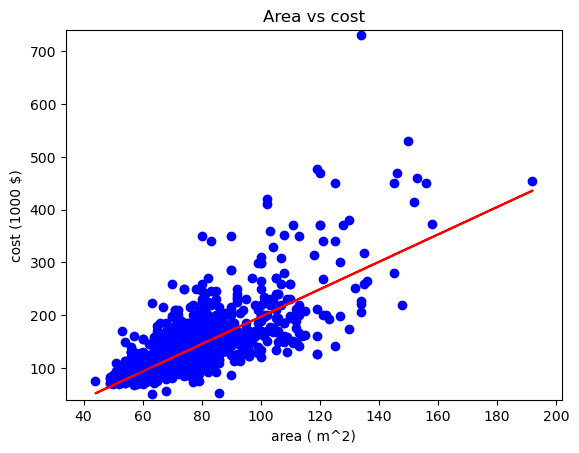

    cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042


In [81]:
# Experiment № 1
# Description: SLR with full dataset (positive relation)

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, positive=False, cnt_sample=0, viz_with_err=False)

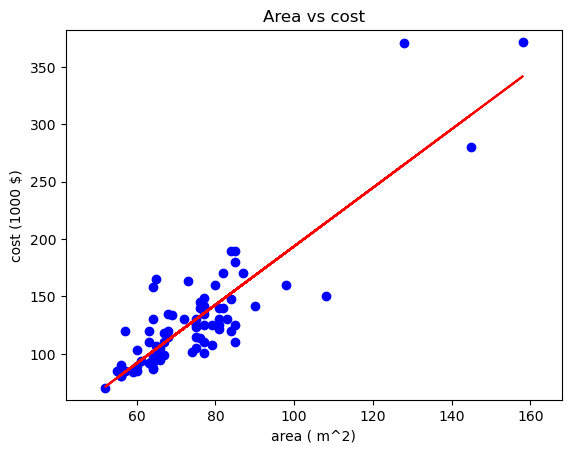

   cnt  Real Y  Predict Y        B1        B2      Sum of E         R
0   79   10208    10208.0 -61.22386  2.549514 -2.842171e-14  0.876035


In [82]:
# Experiment № 2
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0, viz_with_err=False)

Point 1: y_original=128, y_predict=141.65451565317164, error=-13.654515653171643
Point 2: y_original=109, y_predict=141.65451565317164, error=-32.65451565317164
Point 3: y_original=127, y_predict=220.47421734141943, error=-93.47421734141943
Point 4: y_original=110, y_predict=146.2909686936568, error=-36.290968693656794
Point 5: y_original=170, y_predict=174.1096869365678, error=-4.109686936567812
Point 6: y_original=132, y_predict=137.0180626126865, error=-5.018062612686492
Point 7: y_original=105, y_predict=95.28998524831997, error=9.710014751680035
Point 8: y_original=102, y_predict=62.8348139649238, error=39.1651860350762
Point 9: y_original=150, y_predict=155.56387477462715, error=-5.563874774627152
Point 10: y_original=155, y_predict=169.47323389608266, error=-14.473233896082661
Point 11: y_original=153, y_predict=99.92643828880517, error=53.07356171119483
Point 12: y_original=105, y_predict=104.56289132929032, error=0.4371086707096765
Point 13: y_original=80, y_predict=35.0160957

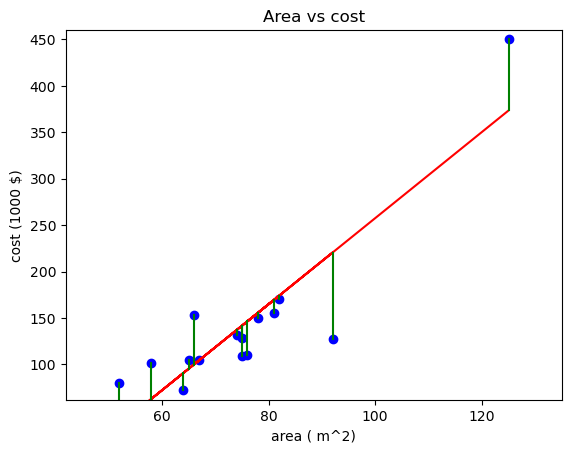

   cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0   15    2148     2148.0 -206.079462  4.636453 -4.547474e-13  0.884751


In [83]:
# Experiment № 3
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, positive=False, cnt_sample=15,  viz_with_err=True)

In [84]:
# Experiment № 4
# Description: many SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=50, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0,  viz_with_err=False)

    cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0    94   12696    12696.0 -104.707085  3.264079 -2.302158e-12  0.746433
1    34    4342     4342.0  -60.479549  2.534986  3.126388e-13  0.796813
2    30    3776     3776.0  -72.682151  2.721089  2.557954e-13  0.926303
3    60    7717     7717.0  -21.921376  2.038430 -5.826450e-13  0.800290
4    56    7091     7091.0  -66.487302  2.646021  1.023182e-12  0.800624
5    22    2504     2504.0  -34.475969  2.063549  5.684342e-14  0.735524
6    89   11462    11462.0 -106.278915  3.202820  5.968559e-13  0.835717
7    43    5734     5734.0  -81.516258  2.912736 -4.547474e-13  0.793220
8    96   12504    12504.0  -83.081277  2.916520 -1.335820e-12  0.816677
9    65    9156     9156.0  -72.687045  2.774467 -8.526513e-13  0.859407
10   91   13279    13279.0 -131.576288  3.623019  8.526513e-13  0.850267
11   26    3299     3299.0    0.079851  1.723431  1.421085e-13  0.706018
12   27    3496     3496.0  -54.452454  2.465847  5